In [6]:
import numpy as np

In [18]:
a=np.array([[1,3],[5,2],[8,6]])
np.sort(a, axis=1)

array([[1, 3],
       [2, 5],
       [6, 8]])

In [30]:
import numpy.linalg as la
import matplotlib.pyplot as plt

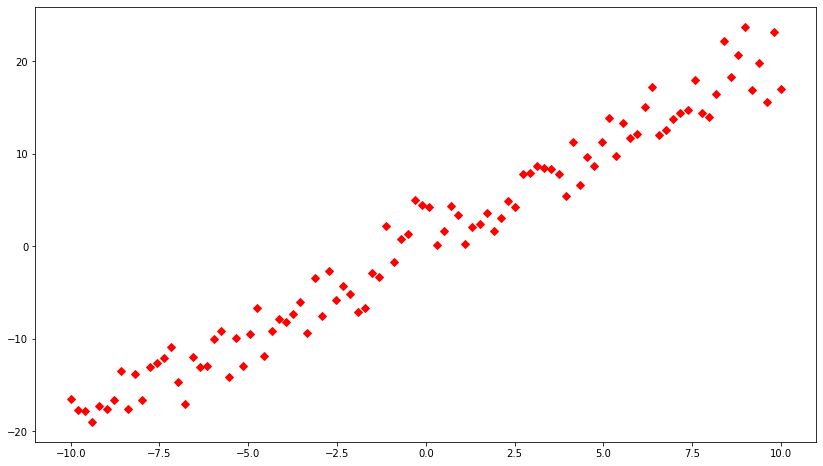

In [36]:
x = np.linspace(-10,10,100)
y = 2*x + 1 + np.random.randn(100)*2
fig = plt.subplots(figsize=(14,8))
plt.plot(x, y,"rD")
plt.show()

In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [34]:
import matplotlib.pyplot as plt

### 离散变量拟合

一般而言，有连续取值的变量叫做连续变量，它的取值可以是任何的实数，或者是某一区间里的任意实数，比如股价、市价等。但有些变量的取值不是连续的，只能有有限个取值，比如交易状态、股票所属行业等，这些变量是离散变量。在回归分析中，需要把离散变量转化为哑变量。

如果想表达有𝑑种取值的离散变量，则对应的哑变量的取值是一个𝑑元组，其中有一个元素为1，其余元素为0。元素为1处就是变量对应的类型。比如离散变量的取值为a、b、c、d，那么类别a对应的哑变量为(1,0,0,0)，类别b对应的哑变量是(0,1,0,0)，类别c对应的哑变量是(0,0,1,0)，类别d对应的哑变量是(0,0,0,1)。假设a、b、c、d四种情况对应的系数为𝛽1、𝛽2、𝛽3、𝛽4，设(𝑧1,𝑧2,𝑧3,𝑧4)是一个取值对应的哑变量，那么

𝛽1𝑧1+𝛽2𝑧2+𝛽3𝑧3+𝛽4𝑧4
可以直接得出相应的系数。可以理解为，离散变量的取值本身只是分类，无法构成任何线性关系，但是若映射到高元的0,1点上，便可以用线性关系表达，从而进行回归。

statsmodels里有一个函数categorical()可以直接把类别0,1,2,...,𝑑−1转化为对应的元组。statsmodels.categorical()的输入有(data, col, dictnames, drop) 四个，中间两个输入可以不管。其中，data是一个𝑛×1的向量，记录每一个样本的分类变量取值；drop是一个Bool值，表示是否在输出中丢掉样本变量值。

设有因变量𝑌，自变量存在连续变量𝑋1和离散变量𝑋2，其中𝑋2的取值范围为{a,b,c}，a类的系数为1，b类的系数为3，c类的系数为8，也就是将𝑋2转化为哑变量(𝑍1,𝑍2,𝑍3)，𝑍𝑖取值为0、1；另外，常数项为10，𝑋1的系数为1，线性方程为

𝑌=10+𝑋1+𝑍1+3𝑍2+8𝑍3+𝜇

In [27]:
nsample = 100                                      # 确定样本量
x1 = np.linspace(0, 20, nsample)                   # 确定连续变量样本

x2 = np.zeros(nsample, int)                        # 定义离散自变量
x2[0:int(nsample/5)] = 0                           # 前20个样本取值为0
x2[int(nsample/5):int(3*nsample/5)] = 1            # 中间20个变量取值为1
x2[int(3*nsample/5):] = 2                          # 最后10个变量取值为2

dummy = sm.categorical(x2, drop=True)              # 离散变量转变为哑变量

X = sm.add_constant(np.column_stack((x1, dummy)))  # 连续变量和哑变量合并，并添加常数项

beta = [10, 1, 1, 3, 8]                            # 确定模型系数真值
mu = np.random.normal(size=nsample)                # 确定模型随机扰动值

y = np.dot(X, beta) + mu                           # 生成解释变量值

result = sm.OLS(y,X).fit()
print(result.params)

[10.95458535  0.93716215 -0.03957652  2.79317949  8.20098238]


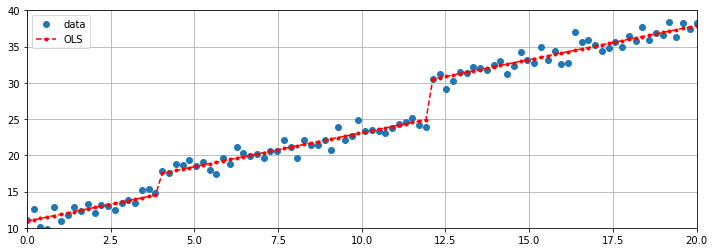

In [35]:
plt.figure(figsize = (12,4))
plt.axis((0, 20, 10, 40))                    # 设置坐标轴区间
plt.grid(True)
plt.plot(x1, y, 'o', label='data')          # 绘出原始数据
plt.plot(x1, result.fittedvalues, 'r--.',label='OLS')  # 绘出拟合数据
plt.legend(loc='best')                     # 添加图注释

### 线性回归模型用于多因子选股（需要wind接口）

In [ ]:
from WindPy import *
w.start()

from datetime import datetime
import pandas as pd
from sklearn import preprocessing
import statsmodels.api as sm

In [ ]:
# 获取模型训练数据

beginDate = "20170101"     # 回测起始日期                                        
endDate = "20180601"       # 回测截止日期

beginDateBefore1 = datetime.strftime(w.tdaysoffset(-1,beginDate).Data[0][0],'%Y%m%d')
monthEndTradeDate=w.tdays(beginDateBefore1, endDate, "Period=M").Data[0][:-1]        #月末交易日

buyInfo = []
for t in range(len(monthEndTradeDate)-1):
    
    endMonthUp = datetime.strftime(monthEndTradeDate[t],'%Y%m%d')
    endMonth = datetime.strftime(monthEndTradeDate[t+1],'%Y%m%d')
    
    # 全A股食品饮料行业个股
    aStock = ','.join(w.wset("sectorconstituent","date="+endMonth+";sectorid=a001010100000000").Data[1])
    aStockIndustry = w.wss(aStock,"industry2","industryType=1;industryStandard=1;tradeDate="+endMonth) 
    foodDrinkCode = []
    for i in range(len(aStockIndustry.Data[0])):
        if aStockIndustry.Data[0][i]=="食品饮料":
            foodDrinkCode.append(aStockIndustry.Codes[i])
    
    # 获取市盈率、市净率、流通市值、换手率、交易状态、涨跌幅数据
    factorDate1 = w.wss(foodDrinkCode, 'pe_ttm,pb_lyr,mkt_freeshares,turn,trade_status,maxupordown',"tradeDate="+endMonthUp)

    # 计算月涨跌幅
    chg = w.wss(foodDrinkCode, "pct_chg_per","startDate="+endMonthUp+";endDate="+endMonth).Data[0]
    
    # 回归数据
    stockData = factorDate1.Data
    stockData.insert(4,chg)
    stockDataDF=pd.DataFrame(stockData,index=["pe_ttm", "pb_lyr", "mkt_freeshares", "turn", "chg", "trade_status", "maxupordown"],columns=factorDate1.Codes).T
    stockDataDF = stockDataDF.dropna()
    
    # 数据标准化
    stockDataDF["chg"] = preprocessing.scale(stockDataDF["chg"])
    stockDataDF["pe_ttm"] = preprocessing.scale(stockDataDF["pe_ttm"])
    stockDataDF["pb_lyr"] = preprocessing.scale(stockDataDF["pb_lyr"])
    stockDataDF["mkt_freeshares"] = preprocessing.scale(stockDataDF["mkt_freeshares"])
    stockDataDF["turn"] = preprocessing.scale(stockDataDF["turn"])
    
    # 数据去极值
    for field in stockDataDF.columns[0:5]:
        mean = np.mean(stockDataDF[field])
        std = np.std(stockDataDF[field])
        upValue = mean + 2*std
        downValue = mean - 2*std        
        for windcode in stockDataDF.index:
            if stockDataDF[field][windcode] > upValue:
                stockDataDF[field][windcode] = upValue
            elif stockDataDF[field][windcode] < downValue:
                stockDataDF[field][windcode] = downValue
    
    X = sm.add_constant(np.column_stack((stockDataDF['pe_ttm'].tolist(), stockDataDF['pb_lyr'].tolist(),stockDataDF['mkt_freeshares'].tolist(),stockDataDF['turn'].tolist()))) 
    y = stockDataDF['chg'].tolist()
    result = sm.OLS(y,X).fit()

    factorDate2 = w.wss(foodDrinkCode, 'pe_ttm,pb_lyr,mkt_freeshares,turn,trade_status,maxupordown',"tradeDate="+endMonth)
    factorDate2DF=pd.DataFrame(factorDate2.Data,index=["pe_ttm","pb_lyr","mkt_freeshares","turn","trade_status","maxupordown"],columns=factorDate2.Codes).T
    factorDate2DF = factorDate2DF[factorDate2DF["trade_status"]=="交易"][factorDate2DF["maxupordown"]==0].dropna()
    
    # 标准化因子数据
    factorDate2DF["pe_ttm"] = preprocessing.scale(factorDate2DF["pe_ttm"])
    factorDate2DF["pb_lyr"] = preprocessing.scale(factorDate2DF["pb_lyr"])
    factorDate2DF["mkt_freeshares"] = preprocessing.scale(factorDate2DF["mkt_freeshares"])
    factorDate2DF["turn"] = preprocessing.scale(factorDate2DF["turn"])
    
    for field in factorDate2DF.columns[0:4]:
        mean = np.mean(factorDate2DF[field])
        std = np.std(factorDate2DF[field])
        upValue = mean + 2*std
        downValue = mean - 2*std        
        for code in factorDate2DF.index:
            if factorDate2DF[field][code] > upValue:
                factorDate2DF[field][code] = upValue
            elif factorDate2DF[field][code] < downValue:
                factorDate2DF[field][code] = downValue
    
    windCode = list(factorDate2DF.index.values)
    
    rawmat = np.mat(factorDate2DF)
    scoreBook = {} 
    selectStock = []
    
    weights = result.params[1:5]
    
    for i in range(len(windCode)):
        secID = windCode[i]
        x = rawmat[i,0:4]
        score = (np.array(np.dot(x,weights)))
        scoreBook.update({secID:score[0][0]}) 
    top5 = sorted(scoreBook.items(), key=lambda scoreBook: scoreBook[1])[-6:-1]  
    
    for i in top5:
        selectStock.append(i[0])    
    
    buyInfo.append(selectStock)   

### 策略回测

In [ ]:
# 获取模型训练数据

beginDate = "20170101"     # 回测起始日期                                        
endDate = "20180601"       # 回测截止日期

beginDateBefore1 = datetime.strftime(w.tdaysoffset(-1,beginDate).Data[0][0],'%Y%m%d')
monthEndTradeDate=w.tdays(beginDateBefore1, endDate, "Period=M").Data[0][:-1]        #月末交易日

buyInfo = []
for t in range(len(monthEndTradeDate)-1):
    
    endMonthUp = datetime.strftime(monthEndTradeDate[t],'%Y%m%d')
    endMonth = datetime.strftime(monthEndTradeDate[t+1],'%Y%m%d')
    
    # 全A股食品饮料行业个股
    aStock = ','.join(w.wset("sectorconstituent","date="+endMonth+";sectorid=a001010100000000").Data[1])
    aStockIndustry = w.wss(aStock,"industry2","industryType=1;industryStandard=1;tradeDate="+endMonth) 
    foodDrinkCode = []
    for i in range(len(aStockIndustry.Data[0])):
        if aStockIndustry.Data[0][i]=="食品饮料":
            foodDrinkCode.append(aStockIndustry.Codes[i])
    
    # 获取市盈率、市净率、流通市值、换手率、交易状态、涨跌幅数据
    factorDate1 = w.wss(foodDrinkCode, 'pe_ttm,pb_lyr,mkt_freeshares,turn,trade_status,maxupordown',"tradeDate="+endMonthUp)

    # 计算月涨跌幅
    chg = w.wss(foodDrinkCode, "pct_chg_per","startDate="+endMonthUp+";endDate="+endMonth).Data[0]
    
    # 回归数据
    stockData = factorDate1.Data
    stockData.insert(4,chg)
    stockDataDF=pd.DataFrame(stockData,index=["pe_ttm", "pb_lyr", "mkt_freeshares", "turn", "chg", "trade_status", "maxupordown"],columns=factorDate1.Codes).T
    stockDataDF = stockDataDF.dropna()
    
    # 数据标准化
    stockDataDF["chg"] = preprocessing.scale(stockDataDF["chg"])
    stockDataDF["pe_ttm"] = preprocessing.scale(stockDataDF["pe_ttm"])
    stockDataDF["pb_lyr"] = preprocessing.scale(stockDataDF["pb_lyr"])
    stockDataDF["mkt_freeshares"] = preprocessing.scale(stockDataDF["mkt_freeshares"])
    stockDataDF["turn"] = preprocessing.scale(stockDataDF["turn"])
    
    # 数据去极值
    for field in stockDataDF.columns[0:5]:
        mean = np.mean(stockDataDF[field])
        std = np.std(stockDataDF[field])
        upValue = mean + 2*std
        downValue = mean - 2*std        
        for windcode in stockDataDF.index:
            if stockDataDF[field][windcode] > upValue:
                stockDataDF[field][windcode] = upValue
            elif stockDataDF[field][windcode] < downValue:
                stockDataDF[field][windcode] = downValue
    
    X = sm.add_constant(np.column_stack((stockDataDF['pe_ttm'].tolist(), stockDataDF['pb_lyr'].tolist(),stockDataDF['mkt_freeshares'].tolist(),stockDataDF['turn'].tolist()))) 
    y = stockDataDF['chg'].tolist()
    result = sm.OLS(y,X).fit()

    factorDate2 = w.wss(foodDrinkCode, 'pe_ttm,pb_lyr,mkt_freeshares,turn,trade_status,maxupordown',"tradeDate="+endMonth)
    factorDate2DF=pd.DataFrame(factorDate2.Data,index=["pe_ttm","pb_lyr","mkt_freeshares","turn","trade_status","maxupordown"],columns=factorDate2.Codes).T
    factorDate2DF = factorDate2DF[factorDate2DF["trade_status"]=="交易"][factorDate2DF["maxupordown"]==0].dropna()
    
    # 标准化因子数据
    factorDate2DF["pe_ttm"] = preprocessing.scale(factorDate2DF["pe_ttm"])
    factorDate2DF["pb_lyr"] = preprocessing.scale(factorDate2DF["pb_lyr"])
    factorDate2DF["mkt_freeshares"] = preprocessing.scale(factorDate2DF["mkt_freeshares"])
    factorDate2DF["turn"] = preprocessing.scale(factorDate2DF["turn"])
    
    for field in factorDate2DF.columns[0:4]:
        mean = np.mean(factorDate2DF[field])
        std = np.std(factorDate2DF[field])
        upValue = mean + 2*std
        downValue = mean - 2*std        
        for code in factorDate2DF.index:
            if factorDate2DF[field][code] > upValue:
                factorDate2DF[field][code] = upValue
            elif factorDate2DF[field][code] < downValue:
                factorDate2DF[field][code] = downValue
    
    windCode = list(factorDate2DF.index.values)
    
    rawmat = np.mat(factorDate2DF)
    scoreBook = {} 
    selectStock = []
    
    weights = result.params[1:5]
    
    for i in range(len(windCode)):
        secID = windCode[i]
        x = rawmat[i,0:4]
        score = (np.array(np.dot(x,weights)))
        scoreBook.update({secID:score[0][0]}) 
    top5 = sorted(scoreBook.items(), key=lambda scoreBook: scoreBook[1])[-6:-1]  
    
    for i in top5:
        selectStock.append(i[0])    
    
    buyInfo.append(selectStock)   

In [44]:
import seaborn as sns
from numpy.random import random_sample

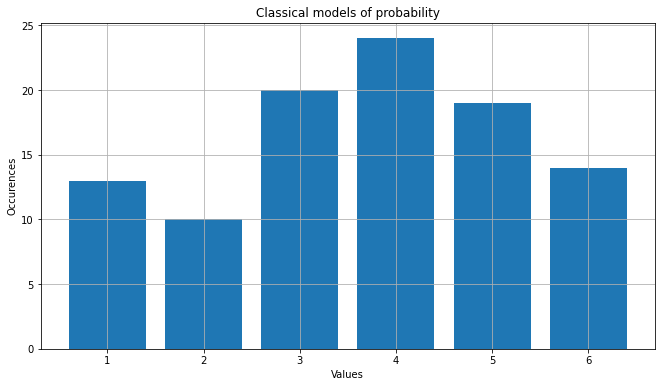

In [63]:
#古典概型掷骰子模拟#

def weighted_values(values, probabilities, size):
    bins = np.add.accumulate(probabilities)
    return values[np.digitize(random_sample(size), bins)]  #values[]中放array相当于按array中的位置取值，得到随机取值的value

values = np.array([1, 2, 3, 4, 5, 6])
probabilities = np.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])

samples = weighted_values(values, probabilities, 100)
counts = []
for value in values:
    counts.append(len(samples[samples==value]))

    
plt.figure(figsize=(11,6))
plt.grid(True)
plt.title("Classical models of probability")
plt.xlabel('Values')
plt.ylabel('Occurences')
plt.bar(values,counts)
plt.show()

In [58]:
rs=random_sample(100)